In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'NSL_regular_season_data_2.csv')
print(data_path)
data = pd.read_csv(data_path)
data.head()

/workspaces/Wharton-HS-Competition-Soccer-Playoff-Predictions/data/NSL_regular_season_data_2.csv


,game_id,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP
0,game_2023_94,TUC,ALB,1,3,2.52,2.00,13,15,3,4,0,0,1,0,0.53
1,game_2023_341,MOB,ALB,3,1,0.46,0.99,11,8,3,6,0,0,0,0,0.56
2,game_2023_442,CHM,ALB,0,1,1.62,1.16,16,13,1,7,0,0,0,0,0.52
3,game_2023_50,SAS,ALB,2,1,1.53,0.55,20,2,6,1,0,0,0,0,0.49
4,game_2023_389,FOR,ALB,0,2,2.15,1.13,18,13,2,0,0,0,0,0,0.71


In [23]:
team_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'NSL_Metadata.csv'))
team_data.head()

,name,city,state,Team_ID,conference,timezone_UTC,Unnamed: 6
0,Albuquerque Scorpions FC,Albuquerque,New Mexico,ALB,Western,-6,NaN
1,Anchorage Avalanche FC,Anchorage,Alaska,ANC,Western,-8,NaN
2,Augusta Arrows FC,Augusta,Georgia,AUG,Eastern,-4,NaN
3,Bakersfield Bandits FC,Bakersfield,California,BAK,Western,-7,NaN
4,Boise Thunderhawks FC,Boise,Idaho,BOI,Western,-6,NaN


In [24]:
# Create a new column called 'Winner' that contains 1 if the home team wins, 0 if the away team wins, and 0.5 if it's a draw
data['Winner'] = np.where(data['HomeScore'] > data['AwayScore'], 1, np.where(data['HomeScore'] < data['AwayScore'], 0, 0.5))

# Create a date column from the matches.
data['GameNumber'] = data['game_id'].str.split('_', expand=True)[2]
data['GameNumber'] = data['GameNumber'].astype(int)
data.drop('game_id', axis=1, inplace=True)
data.head()

,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,Winner,GameNumber
0,TUC,ALB,1,3,2.52,2.00,13,15,3,4,0,0,1,0,0.53,0.0,94
1,MOB,ALB,3,1,0.46,0.99,11,8,3,6,0,0,0,0,0.56,1.0,341
2,CHM,ALB,0,1,1.62,1.16,16,13,1,7,0,0,0,0,0.52,0.0,442
3,SAS,ALB,2,1,1.53,0.55,20,2,6,1,0,0,0,0,0.49,1.0,50
4,FOR,ALB,0,2,2.15,1.13,18,13,2,0,0,0,0,0,0.71,0.0,389


In [25]:
# Order the games by GameNumber
data = data.sort_values(by='GameNumber')

# Make an elo system for the various teams.
elo = {team: 800 for team in team_data['Team_ID']}
elo_over_time = {team: [elo[team]] for team in team_data['Team_ID']}

# Go through each game that the team has played and update their elo
predicted_winner = []
for index, row in data.iterrows():
    team = row['HomeTeam']
    is_win = row['Winner']
    
    # Calculate the expected score
    q_a = 10 ** (elo[row['HomeTeam']] / 400)
    q_b = 10 ** (elo[row['AwayTeam']] / 400)
    e_a = q_a / (q_a + q_b)
    e_b = q_b / (q_a + q_b)

    # Predict the outcome based on the elo
    predicted_winner.append(int(e_a > e_b))

    # Update the elo
    k = 60
    elo[team] = elo[team] + k * (is_win - e_a)
    elo[row['AwayTeam']] = elo[row['AwayTeam']] + k * ((1 - is_win) - e_b)

    # Add the new elo to the elo over time dictionary
    for team in team_data['Team_ID']:
        elo_over_time[team].append(elo[team])

# Add the predicted winner to the dataframe
data['PredictedWinner'] = predicted_winner

# Create a new dataframe with the elo scores
elo_df = pd.DataFrame(elo.items(), columns=['Team_ID', 'Elo'])

# Sort the dataframe by elo
elo_df = elo_df.sort_values(by='Elo', ascending=False)
elo_df



,Team_ID,Elo
2,AUG,1030.445538
12,LAR,930.771531
11,JAC,904.333822
9,FAR,887.680704
18,PRO,865.340498
17,OAK,856.811019
1,ANC,853.861378
14,LRO,831.487966
21,SFS,826.625548
13,LEX,824.624543


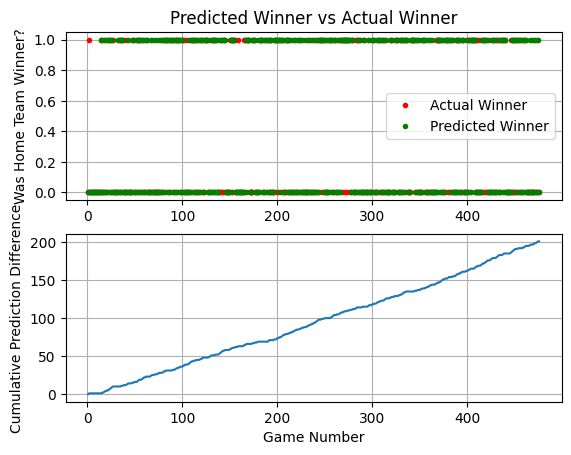

In [26]:
# Treat draws as losses
data['Winner'] = np.where(data['Winner'] == 0.5, 0, data['Winner'])

# Plot the predicted winner vs the actual winner
plt.subplot(2, 1, 1)
plt.plot(data['GameNumber'], data['Winner'], 'r.')
plt.plot(data['GameNumber'], data['PredictedWinner'], 'g.')
plt.ylabel('Was Home Team Winner?')
plt.title('Predicted Winner vs Actual Winner')
plt.legend(['Actual Winner', 'Predicted Winner'], loc='center right')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(data['GameNumber'], np.cumsum(np.abs(data['PredictedWinner'] - data['Winner'])))
plt.xlabel('Game Number')
plt.ylabel('Cumulative Prediction Difference')
plt.grid()

In [27]:
# Test the accuracy of the predicted elo system
accuracy = np.mean(data['Winner'] == data['PredictedWinner'])
print(f'Accuracy of the elo system: {accuracy}')

Accuracy of the elo system: 0.5777310924369747


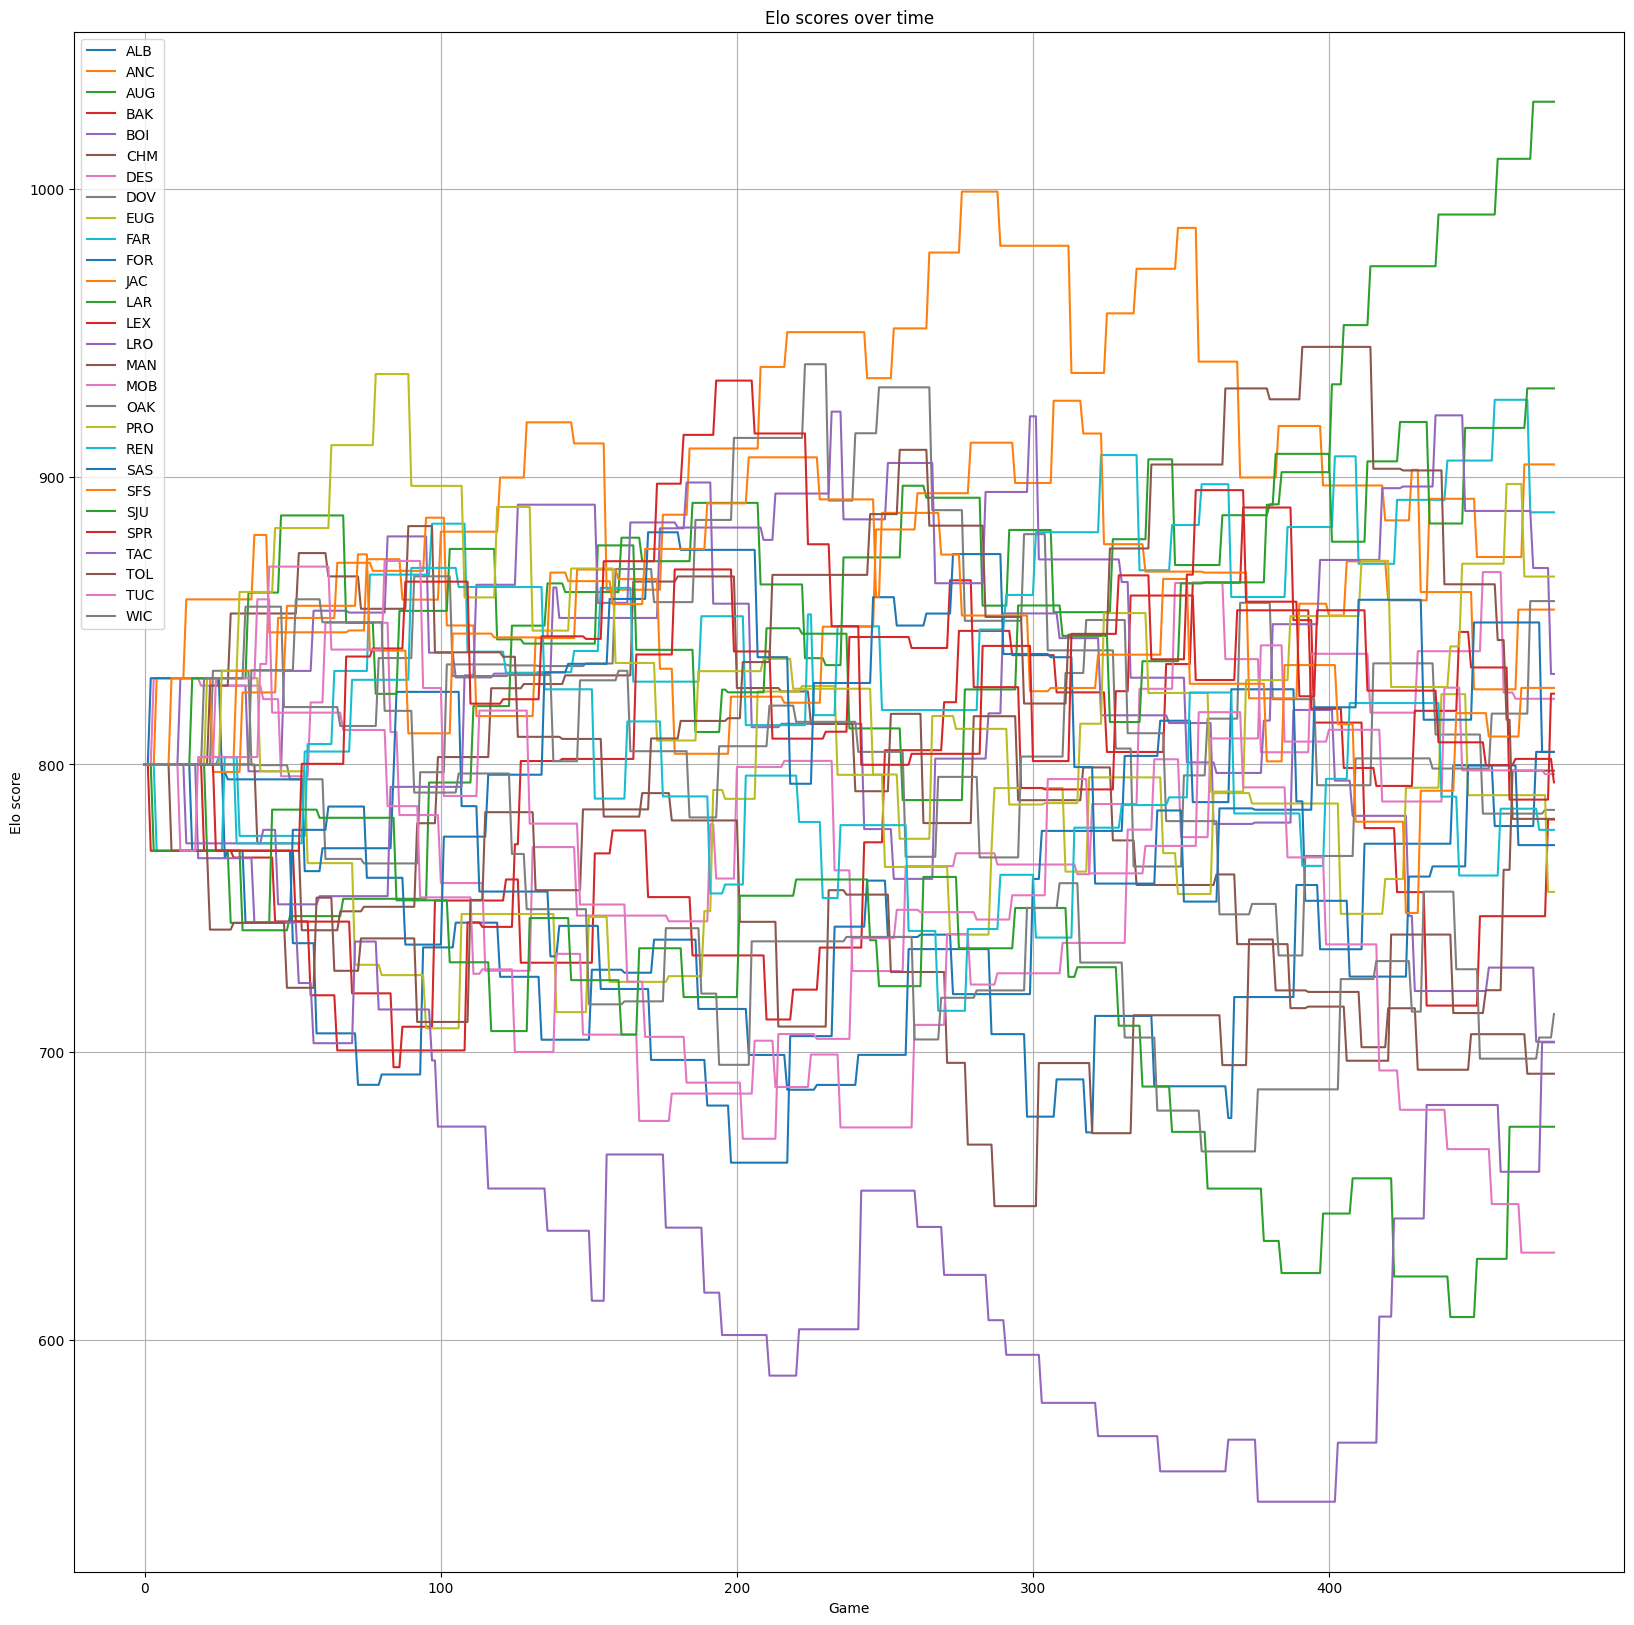

In [28]:
# Plot the elo scores over time
plt.figure(figsize=(20, 20))
for team in team_data['Team_ID']:
    plt.plot(elo_over_time[team], label=team)
plt.legend(loc='upper left')
plt.title('Elo scores over time')
plt.xlabel('Game')
plt.ylabel('Elo score')
plt.grid()